In [1]:
MAX_SEQUENCE_LENGTH = 1400 # 句子 上限1400个词
EMBEDDING_DIM = 100 # 100d 词向量

### 数据集
HTTP DATASET CSIC 2010: http://www.isi.csic.es/dataset/

In [2]:
# 获取数据集
# GET 以 Connection + /n + /n 结尾
# POST 以 Content-Length + /n + params + /n 结尾

def read_data(path):
    data = []
    labels = []
    with open(path) as f:
        while True:
            line = f.readline()
            content = line
            if line == '': break 
            if line[:3] == 'GET':
                while True:
                    line = f.readline()
                    if line[:10] == 'Connection': break
                    else: content += line
                f.readline() # none
                f.readline() # none
            elif line[:4] == 'POST':
                while True:
                    line = f.readline()
                    if line[:14] == 'Content-Length': break
                    else: content += line
                f.readline() # none
                content += f.readline()
                f.readline() # none
            data.append(content)
    return data

data1 = 'data/normalTrafficTest.txt'
data2 = 'data/normalTrafficTraining.txt'
data3 = 'data/anomalousTrafficTest.txt'
X1 = read_data(data1)
X2 = read_data(data2)
X3 = read_data(data3)
print(len(X1), len(X2), len(X3))

36000 36000 31020


In [3]:
data = []
labels = []
data.extend(X1)
labels.extend([1] * len(X1))
data.extend(X2)
labels.extend([1] * len(X2))
data.extend(X3)
labels.extend([0] * len(X3))
print(len(data), len(labels))

103020 103020


In [4]:
data[0]

'GET http://localhost:8080/tienda1/index.jsp HTTP/1.1\nUser-Agent: Mozilla/5.0 (compatible; Konqueror/3.5; Linux) KHTML/3.5.8 (like Gecko)\nPragma: no-cache\nCache-control: no-cache\nAccept: text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q=0.8,image/png,*/*;q=0.5\nAccept-Encoding: x-gzip, x-deflate, gzip, deflate\nAccept-Charset: utf-8, utf-8;q=0.5, *;q=0.5\nAccept-Language: en\nHost: localhost:8080\nCookie: JSESSIONID=EA414B3E327DED6875848530C864BD8F\n'

In [5]:
data[2]

'POST http://localhost:8080/tienda1/publico/anadir.jsp HTTP/1.1\nUser-Agent: Mozilla/5.0 (compatible; Konqueror/3.5; Linux) KHTML/3.5.8 (like Gecko)\nPragma: no-cache\nCache-control: no-cache\nAccept: text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q=0.8,image/png,*/*;q=0.5\nAccept-Encoding: x-gzip, x-deflate, gzip, deflate\nAccept-Charset: utf-8, utf-8;q=0.5, *;q=0.5\nAccept-Language: en\nHost: localhost:8080\nCookie: JSESSIONID=788887A0F479749C4CEEA1E268B4A501\nContent-Type: application/x-www-form-urlencoded\nConnection: close\nid=1&nombre=Jam%F3n+Ib%E9rico&precio=39&cantidad=41&B1=A%F1adir+al+carrito\n'

### 字向量

In [6]:
# https://keras-cn-docs.readthedocs.io/zh_CN/latest/blog/word_embedding/
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# tokenizer
texts = data
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

# sequences
sequences = tokenizer.texts_to_sequences(data)

# padding
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Found %s unique tokens.' % len(word_index))
print('Shape of data tensor:', data.shape)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 80 unique tokens.
Shape of data tensor: (103020, 1400)


In [7]:
import pickle

token_path = 'model/tokenizer.pkl'
pickle.dump(tokenizer, open(token_path, 'wb'))

In [8]:
import random

# 打乱顺序
index = [i for i in range(len(data))]
random.shuffle(index)
data = np.array(data)[index]
labels = np.array(labels)[index]

TRAIN_SPLIT = 0.8 # 20% 测试集
TRAIN_SIZE = int(len(data) * TRAIN_SPLIT)

X_train, X_test = data[0:TRAIN_SIZE], data[TRAIN_SIZE:]
Y_train, Y_test = labels[0:TRAIN_SIZE], labels[TRAIN_SIZE:]

In [9]:
print('train len:', len(X_train))
print('test len:', len(X_test))

train len: 82416
test len: 20604


### 训练

In [10]:
import tensorflow as tf
from keras import backend as K

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

G = 1 # GPU 数量
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
session = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, allow_soft_placement=True))
K.set_session(session)

### CNN + Bi-LSTM

In [11]:
from keras.models import Sequential
from keras.layers import Activation, BatchNormalization, Flatten
from keras.layers import Dense, LSTM, Convolution1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.layers.wrappers import Bidirectional

QA_EMBED_SIZE = 64
DROPOUT_RATE = 0.3

model = Sequential()
model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(Convolution1D(filters=128, kernel_size=3, padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(4))
model.add(Bidirectional(LSTM(QA_EMBED_SIZE, return_sequences=False, dropout=DROPOUT_RATE, recurrent_dropout=DROPOUT_RATE)))

model.add(Dense(QA_EMBED_SIZE))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(1))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1400, 100)         8100      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1398, 128)         38528     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1398, 128)         512       
_________________________________________________________________
activation_1 (Activation)    (None, 1398, 128)         0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 349, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
__________

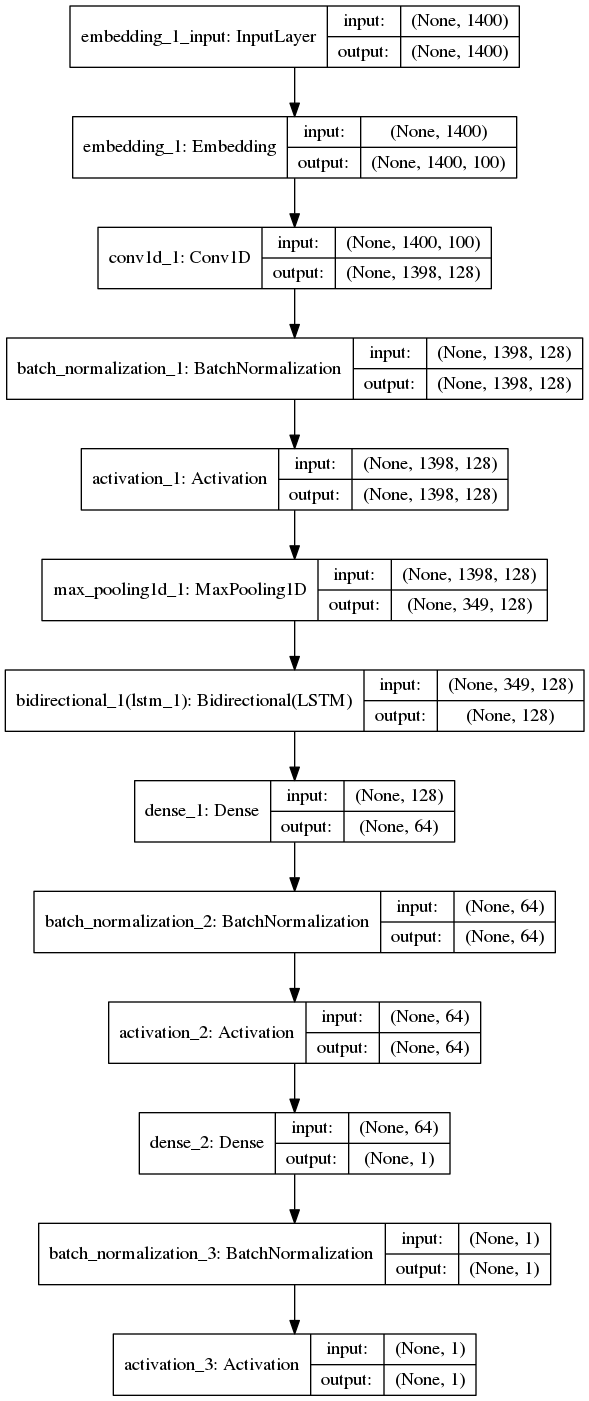

In [12]:
# 模型可视化 https://keras-cn.readthedocs.io/en/latest/other/visualization/
from keras.utils import plot_model
from IPython import display

# pip install pydot=1.2.3
# pip install pydot-ng
# sudo apt-get install graphviz
plot_model(model, to_file="img/model-cnn-blstm.png", show_shapes=True)
display.Image('img/model-cnn-blstm.png')

In [13]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.utils import multi_gpu_model
from evaluate import *

EPOCHS = 5
BATCH_SIZE = 64 * G
VALIDATION_SPLIT = 0.3 # 30% 验证集

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_path = 'model/model-cnn-blstm.h5'
model_checkpoint = ModelCheckpoint(model_path, save_best_only=True, save_weights_only=True)
tensorboard = TensorBoard('log/tflog-cnn-blstm', write_graph=True, write_images=True)

# model = multi_gpu_model(model)

model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', precision, recall, f1])

model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
          validation_split=VALIDATION_SPLIT, shuffle=True, 
          callbacks=[early_stopping, model_checkpoint, tensorboard])

Train on 57691 samples, validate on 24725 samples
Epoch 1/5
57691/57691 [==============================] - 1098s 19ms/step - loss: 0.4462 - acc: 0.8285 - precision: 0.8362 - recall: 0.9460 - f1: 0.8847 - val_loss: 0.1520 - val_acc: 0.9774 - val_precision: 0.9748 - val_recall: 0.9932 - val_f1: 0.9837
Epoch 2/5
57691/57691 [==============================] - 1096s 19ms/step - loss: 0.1362 - acc: 0.9801 - precision: 0.9793 - recall: 0.9925 - f1: 0.9857 - val_loss: 0.0900 - val_acc: 0.9855 - val_precision: 0.9859 - val_recall: 0.9933 - val_f1: 0.9895
Epoch 3/5
57691/57691 [==============================] - 1109s 19ms/step - loss: 0.0838 - acc: 0.9853 - precision: 0.9844 - recall: 0.9948 - f1: 0.9895 - val_loss: 0.0587 - val_acc: 0.9893 - val_precision: 0.9877 - val_recall: 0.9970 - val_f1: 0.9922
Epoch 4/5
57691/57691 [==============================] - 1107s 19ms/step - loss: 0.0602 - acc: 0.9883 - precision: 0.9870 - recall: 0.9964 - f1: 0.9916 - val_loss: 0.0418 - val_acc: 0.9907 - val_pr

In [14]:
model.evaluate(X_test, Y_test, verbose=1, batch_size=BATCH_SIZE)

20604/20604 [==============================] - 78s 4ms/step


[0.0360177080261779,
 0.9910696952511004,
 0.9892460173992156,
 0.9979366264720955,
 0.9934972989006057]